**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

C:\Users\ivtpr\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#@ READING DATASET:
PATH = "./week6/housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [3]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [4]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
#np.log1p
df.median_house_value = np.log1p(df.median_house_value)


In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
df_train

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
9107     -118.18     34.63                19.0       3562.0           606.0   
13999    -116.90     34.69                10.0        337.0           102.0   
5610     -118.26     33.78                27.0       1672.0           491.0   
13533    -117.33     34.17                 5.0       4718.0          1140.0   
2953     -119.02     35.35                42.0       1239.0           251.0   
...          ...       ...                 ...          ...             ...   
4482     -118.19     34.06                32.0        555.0           159.0   
1835     -122.30     37.90                37.0       2125.0           489.0   
8539     -118.36     33.90                18.0       3380.0           922.0   
2155     -119.79     36.78                41.0       2227.0           462.0   
13351    -117.62     34.02                 9.0       4265.0           587.0   

       population  households  median_income  median_house_value  \
9107       1677.0       578.0         4.1573           12.337544   
13999       108.0        50.0         0.4999           10.915107   
5610       1723.0       462.0         2.0458           12.069686   
13533      2564.0      1056.0         2.9877           11.694422   
2953        776.0       272.0         1.9830           11.055656   
...           ...         ...            ...                 ...   
4482        748.0       163.0         1.9762           11.831386   
1835        912.0       462.0         2.9219           12.288578   
8539       2276.0       854.0         4.0727           12.273736   
2155       1129.0       415.0         2.3190           10.987003   
13351      2280.0       589.0         5.5632           12.181273   

      ocean_proximity  
9107           INLAND  
13999          INLAND  
5610       NEAR OCEAN  
13533          INLAND  
2953           INLAND  
...               ...  
4482        <1H OCEAN  
1835         NEAR BAY  
8539        <1H OCEAN  
2155           INLAND  
13351          INLAND  

[12384 rows x 10 columns]

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
df_train.median_house_value.describe()

count    12384.000000
mean        12.088319
std          0.567343
min          9.615805
25%         11.697752
50%         12.102937
75%         12.485695
max         13.122367
Name: median_house_value, dtype: float64

In [8]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']


In [18]:
df.describe().round()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
count    20640.0   20640.0             20640.0      20640.0         20640.0   
mean      -120.0      36.0                29.0       2636.0           532.0   
std          2.0       2.0                13.0       2182.0           423.0   
min       -124.0      33.0                 1.0          2.0             0.0   
25%       -122.0      34.0                18.0       1448.0           292.0   
50%       -118.0      34.0                29.0       2127.0           431.0   
75%       -118.0      38.0                37.0       3148.0           643.0   
max       -114.0      42.0                52.0      39320.0          6445.0   

       population  households  median_income  median_house_value  452600.0  \
count     20640.0     20640.0        20640.0             20640.0   20640.0   
mean       1425.0       500.0            4.0                12.0      13.0   
std        1132.0       382.0            2.0                 1.0       0.0   
min           3.0         1.0            0.0                10.0      13.0   
25%         787.0       280.0            3.0                12.0      13.0   
50%        1166.0       409.0            4.0                12.0      13.0   
75%        1725.0       605.0            5.0                12.0      13.0   
max       35682.0      6082.0           15.0                13.0      13.0   

       ...  206600.0  423300.0  399400.0  423400.0  251700.0  422900.0  \
count  ...   20640.0   20640.0   20640.0   20640.0   20640.0   20640.0   
mean   ...      12.0      13.0      13.0      13.0      12.0      13.0   
std    ...       0.0       0.0       0.0       0.0       0.0       0.0   
min    ...      12.0      13.0      13.0      13.0      12.0      13.0   
25%    ...      12.0      13.0      13.0      13.0      12.0      13.0   
50%    ...      12.0      13.0      13.0      13.0      12.0      13.0   
75%    ...      12.0      13.0      13.0      13.0      12.0      13.0   
max    ...      12.0      13.0      13.0      13.0      12.0      13.0   

       349400.0  425800.0  200700.0  47000.0  
count   20640.0   20640.0   20640.0  20640.0  
mean       13.0      13.0      12.0     11.0  
std         0.0       0.0       0.0      0.0  
min        13.0      13.0      12.0     11.0  
25%        13.0      13.0      12.0     11.0  
50%        13.0      13.0      12.0     11.0  
75%        13.0      13.0      12.0     11.0  
max        13.0      13.0      12.0     11.0  

[8 rows x 3851 columns]

- We will use `DictVectorizer` to turn train and validation into matrices.

In [31]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
dicts_train = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

dicts_val = df_val.to_dict(orient='records')
X_val = dv.transform(dicts_val)

In [12]:
X_train

array([[ 578.  ,   19.  ,   34.63, ..., 1677.  ,  606.  , 3562.  ],
       [  50.  ,   10.  ,   34.69, ...,  108.  ,  102.  ,  337.  ],
       [ 462.  ,   27.  ,   33.78, ..., 1723.  ,  491.  , 1672.  ],
       ...,
       [ 854.  ,   18.  ,   33.9 , ..., 2276.  ,  922.  , 3380.  ],
       [ 415.  ,   41.  ,   36.78, ..., 1129.  ,  462.  , 2227.  ],
       [ 589.  ,    9.  ,   34.02, ..., 2280.  ,  587.  , 4265.  ]])

In [19]:
from sklearn.metrics import roc_auc_score

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [21]:
#@ TRAINING THE REGRESSION MODEL:
regressor = DecisionTreeRegressor(max_depth=1)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_train)
y_pred

array([11.61333344, 11.61333344, 12.30674657, ..., 12.30674657,
       11.61333344, 11.61333344])

In [22]:
#@ INSPECTION:
from sklearn.tree import export_text

- Which feature is used for splitting the data?

- Answer: ocean_proximity

In [27]:
print(export_text(regressor,feature_names=dv.get_feature_names()) )

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [34]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)


y_pred_rf = rf.predict(X_val)
#roc_auc_score(y_val, y_pred_rf)

In [36]:
#@ CALCULATING MEAN SQUARED ERROR:
rmse = np.sqrt(mean_squared_error(y_val,y_pred_rf))
rmse

0.2457383433183843

- What's the RMSE of this model on validation?

- Answer: 0.25

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [39]:
#@ TRAINING THE RANDOM FOREST MODEL:

results =[]
for n_est in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n_est, random_state=1)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val,y_pred_rf))
    print(n_est, rmse)
    results.append((n_est, rmse))
    
columns =['num_iter', 'rmse']
df_results = pd.DataFrame(results, columns=columns)
    
    

10 0.2457383433183843
20 0.23926159143162362
30 0.23571658024242995
40 0.2345829928852663
50 0.23310354554874652
60 0.2328429808263216
70 0.23238404627057696
80 0.2325270885881096
90 0.2322152441944244
100 0.2319683398110155
110 0.2315183513876384
120 0.23162059722289452
130 0.23170961618874023
140 0.23169246809784283
150 0.23169445775520764
160 0.23169721161526824
170 0.23162910205851622
180 0.2317902360719715
190 0.2317624141810945
200 0.23165006514034595


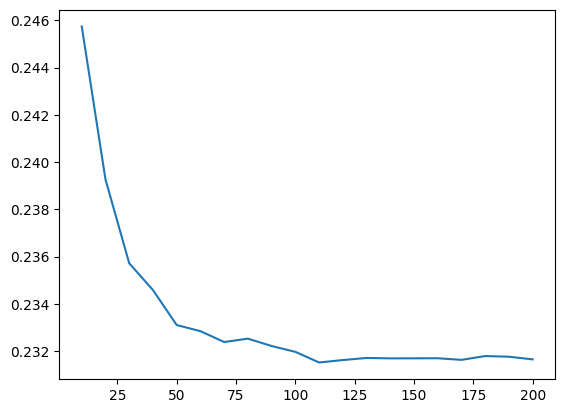

In [40]:
#@ INSPECTING THE RMSE SCORES:
plt.plot(df_results.num_iter, df_results.rmse, label='val')


- After which value of `n_estimators` does RMSE stop improving?

- Answer: 75

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [42]:
#@ TRAINING THE MODEL WITH DEPTH:
results =[]
for n_dept in [10,15,20,25]:
    for n_est in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n_est, max_depth=n_dept, random_state=1)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val,y_pred_rf))
        print(n_dept, n_est, rmse)
        results.append((n_dept, n_est, rmse))
    
columns =['max_dept','num_iter', 'rmse']
df_results = pd.DataFrame(results, columns=columns)


df_results_pivot = df_results.pivot(index='num_iter',columns=['max_dept'], values=['rmse'])
df_results_pivot

sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

10 10 0.25504160871076226
10 20 0.2527843628111254
10 30 0.25164651106868285
10 40 0.2510617356366555
10 50 0.2501924996109377
10 60 0.25009613605670555
10 70 0.24991662218794553
10 80 0.24959018682670703
10 90 0.24931387548986406
10 100 0.24915438732328005
10 110 0.24890494450291387
10 120 0.2489692787772818
10 130 0.2490994489918707
10 140 0.24920575579859985
10 150 0.24919143624423534
10 160 0.24911488721352457
10 170 0.24890022800447834
10 180 0.24900930356623044
10 190 0.24908309742304938
10 200 0.24910554094143506
15 10 0.24479009739308974
15 20 0.2393064768432696
15 30 0.23690899332310014
15 40 0.23598320832282838
15 50 0.23472976205475554
15 60 0.23465620779540475
15 70 0.2341061444995546
15 80 0.23396237196709047
15 90 0.23377586377559464
15 100 0.23353976973246615
15 110 0.23316836533579854
15 120 0.23321709249918968
15 130 0.23330996871531756
15 140 0.23325447197960603
15 150 0.23319835806483816
15 160 0.23314363473022764
15 170 0.23311174668233933
15 180 0.2332367209924553


KeyError: 'max_depth'

In [46]:
df_results

max_dept  num_iter      rmse
0         10        10  0.255042
1         10        20  0.252784
2         10        30  0.251647
3         10        40  0.251062
4         10        50  0.250192
..       ...       ...       ...
75        25       160  0.231484
76        25       170  0.231440
77        25       180  0.231598
78        25       190  0.231603
79        25       200  0.231492

[80 rows x 3 columns]

In [50]:
df_results.sort_values(by='rmse', ascending=False).head()

max_dept  num_iter      rmse
0        10        10  0.255042
1        10        20  0.252784
2        10        30  0.251647
3        10        40  0.251062
4        10        50  0.250192

In [51]:
df_results_pivot = df_results.pivot(index='num_iter',columns=['max_dept'], values=['rmse'])
df_results_pivot



rmse                              
max_dept        10        15        20        25
num_iter                                        
10        0.255042  0.244790  0.246327  0.246069
20        0.252784  0.239306  0.238937  0.238804
30        0.251647  0.236909  0.235886  0.235454
40        0.251062  0.235983  0.234844  0.234338
50        0.250192  0.234730  0.233411  0.232747
60        0.250096  0.234656  0.233427  0.232506
70        0.249917  0.234106  0.232949  0.232007
80        0.249590  0.233962  0.232876  0.231905
90        0.249314  0.233776  0.232677  0.231669
100       0.249154  0.233540  0.232469  0.231563
110       0.248905  0.233168  0.232139  0.231255
120       0.248969  0.233217  0.232118  0.231297
130       0.249099  0.233310  0.232160  0.231530
140       0.249206  0.233254  0.231983  0.231458
150       0.249191  0.233198  0.232032  0.231511
160       0.249115  0.233144  0.232002  0.231484
170       0.248900  0.233112  0.231939  0.231440
180       0.249009  0.233237  0.232118  0.231598
190       0.249083  0.233337  0.232054  0.231603
200       0.249106  0.233260  0.231893  0.231492

In [52]:
sns.heatmap(df_results_pivot, annot=True, fmt='.3f')

<AxesSubplot:xlabel='None-max_dept', ylabel='num_iter'>

- What's the best `max_depth`:

- Answer: 25

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [53]:
#@ TRAINING THE RANDOM FOREST MODEL:


rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val,y_pred_rf))
print(n_dept, n_est, rmse)

rf.feature_importances_

importances = list(zip(dv.feature_names_, rf.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance




25 200 0.2463272470947511


feature      gain
4                median_income  0.362913
6       ocean_proximity=INLAND  0.310901
2                     latitude  0.101334
3                    longitude  0.096265
1           housing_median_age  0.033094
10                  population  0.030918
12                 total_rooms  0.020536
11              total_bedrooms  0.019041
0                   households  0.016957
9   ocean_proximity=NEAR OCEAN  0.004228
5    ocean_proximity=<1H OCEAN  0.003007
8     ocean_proximity=NEAR BAY  0.000449
7       ocean_proximity=ISLAND  0.000357

- What's the most important feature?

- Answer: median_income

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [54]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [56]:
watchlist =[(dtrain, 'train'),(dval,'val')]

In [60]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                  verbose_eval=5, 
                  evals=watchlist)

y_pred=model.predict(dval)


rmse = np.sqrt(mean_squared_error(y_val,y_pred))

rmse

[0]	train-rmse:8.12733	val-rmse:8.13245
[5]	train-rmse:1.40218	val-rmse:1.40741
[10]	train-rmse:0.34481	val-rmse:0.35782
[15]	train-rmse:0.23555	val-rmse:0.26044
[20]	train-rmse:0.21580	val-rmse:0.24624
[25]	train-rmse:0.20395	val-rmse:0.24099
[30]	train-rmse:0.19440	val-rmse:0.23741
[35]	train-rmse:0.18637	val-rmse:0.23562
[40]	train-rmse:0.17983	val-rmse:0.23419
[45]	train-rmse:0.17468	val-rmse:0.23279
[50]	train-rmse:0.16934	val-rmse:0.23097
[55]	train-rmse:0.16546	val-rmse:0.23039
[60]	train-rmse:0.16177	val-rmse:0.22950
[65]	train-rmse:0.15762	val-rmse:0.22857
[70]	train-rmse:0.15323	val-rmse:0.22787
[75]	train-rmse:0.15010	val-rmse:0.22755
[80]	train-rmse:0.14564	val-rmse:0.22611
[85]	train-rmse:0.14166	val-rmse:0.22579
[90]	train-rmse:0.13892	val-rmse:0.22628
[95]	train-rmse:0.13553	val-rmse:0.22630
[99]	train-rmse:0.13299	val-rmse:0.22610


0.2260957847928297

In [61]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                  verbose_eval=5, 
                  evals=watchlist)

y_pred=model.predict(dval)


rmse = np.sqrt(mean_squared_error(y_val,y_pred))

rmse

[0]	train-rmse:10.44372	val-rmse:10.44938
[5]	train-rmse:6.17513	val-rmse:6.17987
[10]	train-rmse:3.65741	val-rmse:3.66135
[15]	train-rmse:2.17500	val-rmse:2.17928
[20]	train-rmse:1.30499	val-rmse:1.31054
[25]	train-rmse:0.79933	val-rmse:0.80657
[30]	train-rmse:0.51144	val-rmse:0.52189
[35]	train-rmse:0.35700	val-rmse:0.37264
[40]	train-rmse:0.27984	val-rmse:0.30053
[45]	train-rmse:0.24350	val-rmse:0.26829
[50]	train-rmse:0.22614	val-rmse:0.25334
[55]	train-rmse:0.21695	val-rmse:0.24657
[60]	train-rmse:0.21035	val-rmse:0.24189
[65]	train-rmse:0.20579	val-rmse:0.23943
[70]	train-rmse:0.20116	val-rmse:0.23684
[75]	train-rmse:0.19680	val-rmse:0.23507
[80]	train-rmse:0.19384	val-rmse:0.23398
[85]	train-rmse:0.19085	val-rmse:0.23275
[90]	train-rmse:0.18794	val-rmse:0.23206
[95]	train-rmse:0.18541	val-rmse:0.23106
[99]	train-rmse:0.18329	val-rmse:0.23054


0.2305416021993131

- Now, change eta first to 0.1 and then to 0.01.

- Which eta leads to the best RMSE score on the validation dataset?

- Answer: 0.3